In [80]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from PIL import Image
import cv2 
import csv

# comments from Sanli

## general comments
+ in between each two code cells in the notebook, the MUST be a markdown cell explaining what are you trying to achieve in the next step and why. 
+ if you have to copy and paste a part of code to perform some action multiple times, it is a good indication that part of your code has to be in a function. 
+ each time you introduce a new variable and assign an input, you have to explain what is that variable

## technical comments

I am going to put my technical comments on your code also in these cells.

+ for the next cell, you use a file listing to generate your input data. you cannot be sure that the directory list is in the correct order if you do not construct the path by yourself from the numbers.

## Description

* In this line, we want to decrease the shot noise in images to make low noise more contrast.
* We capture the image of cell in 10 minutes which produce ~6200 images and ~120 cycles.
* Each cycle produces 50 images (25 images for charge, 25 images for discharge).
* We want to call the image from basler folder. 
* To be able to use the code, change the path of files.
* There are 2 filelist that will be used, without heat (filename: m009) and heat by temperature 60C (filename: 011).
* We do looping to call images at first time position for each cycle and convert it to array.
* Then, we calculate the average intensity of images, background correction, and normalization 

In [95]:
#Call the images
def image_proc(fname):
    global pixel_ar, avg, delta_I, norm, N_cycles
   
    #Call images
    filename    = fname #intensity no temperature
    file_list   = glob.glob(filename)
    fpp         = 50
    N_cycles    = len(file_list) // fpp
    file_list   = file_list[:(fpp*N_cycles)]
    img_shape   = np.array(Image.open(file_list[0])).shape
    
    #Call every 50 frames
    pixel   = []
    for i_f in range(1):
        sibling_frames = np.empty((img_shape[0], img_shape[1], N_cycles))
        for i_c in range(N_cycles):
            img   = Image.open(file_list[i_f + i_c * fpp])
            sibling_frames[:,:,i_c] = np.array(img, dtype=float)  
            pixel.append(sibling_frames[:,:,i_c]) 
    
    pixel_ar = np.array(pixel)

    #Average frames
    avg      = np.mean(pixel_ar, axis=0)

    #Background correction and normalization
    delta_I  = pixel_ar - avg
    norm     = delta_I / avg

In [98]:
image_proc("m009/basler/*.bmp")
pixel_1, avg_1, delta_I_1, norm_1 = pixel_ar, avg, delta_I, norm
image_proc("m011/basler/*.bmp")
pixel_2, avg_2, delta_I_2, norm_2 = pixel_ar, avg, delta_I, norm

<center>----------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center> 

## technical comments

+ why is this specific file chosen?

same comment for all the cells after this one.

## Description

* This to see what background correction and normalisation looks like in an image
* A video of all the corrected frames can be produced
* Individual frames can be analysed

In [108]:
#Saves the normalised images into the corresponding folder
def save_image(array, name):
    for x in range(N_cycles):
        plt.imsave(f"C:/Users/experiment/Documents/data/m{name}/image/im__{x:04}.bmp", array[x,:,:])

#To make a video from normalised images
def record_img(files,name):
    img_2  = []
    f_name = files
    for fn in glob.glob(f_name):
        img  = cv2.imread(fn)
        img_2.append(img)
    #Create video
    height, width, layers = img.shape
    size   = (width,height)
    out    = cv2.VideoWriter(f'C:/Users/experiment/Documents/data/Recording_{name}.avi', cv2.VideoWriter_fourcc(*'DIVX'),3,size)
    
    for i in range(N_cycles):
        out.write(img_2[i])
    cv2.destroyAllWindows()
    out.release

In [37]:
save_image(norm,"009") #put the variable and the desired folder for placement

In [38]:
record_img("C:/Users/experiment/Documents/data/m009/image/*.bmp", "1")
# record_img("E:/m014/image/*.bmp", "2")

<center>----------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center> 

## technical comments

+ graphs need a description of their purpose. are these intensity at one point or average over some axis. what do you want to show?

## Description

* In this line, we would like to plot the change in intensity after background correction and normalization.
* The array that we use, represent the image in the first time-position for each cycles.
* To plot the data, we average the intensity of images for raw images, background correction images, and normalization images.


In [99]:
#Show the result of background correction and normalisation in graph
def plot_graph(array, title): 
    plt.plot(np.mean(np.mean(array, axis =2), axis=1))
    plt.xlabel('frames'),plt.ylabel('intensity')
    plt.title(title)

def image_correction(array, title):
    plt.imshow(array[0,:,:])
    plt.axis('off')
    plt.title(title)

def sub_plot(width,length,row,col):
    global fig, rows, cols
    fig   = plt.figure(figsize=(width, length))
    rows  = row
    cols  = col

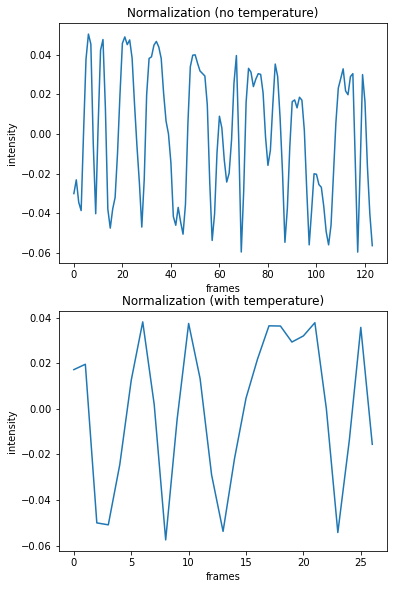

In [150]:
#Plots arrays of the images
sub_plot(20,15,3,3)
# fig.add_subplot(rows, cols, 1)
# plot_graph(pixel_1,"Array (no temperature)")
# fig.add_subplot(rows, cols, 2)
# plot_graph(delta_I_1,"BG_Corr (no temperature)")
fig.add_subplot(rows, cols, 3)
plot_graph(norm_1, "Normalization (no temperature)")
# fig.add_subplot(rows, cols, 4)
# plot_graph(pixel_2, "Array (with temperature)")
# fig.add_subplot(rows, cols, 5)
# plot_graph(delta_I_2, "BG_Corr (with temperature)")
fig.add_subplot(rows, cols, 6)
plot_graph(norm_2, "Normalization (with temperature)")

Interesting point at (1, 87, 403)


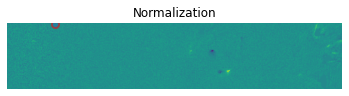

In [149]:
# sub_plot(20,3,2,3)
# fig.add_subplot(rows, cols, 1)
# image_correction(pixel_2, "Array")
# fig.add_subplot(rows, cols, 2)
# image_correction(delta_I_2, "BG_Corr")
# fig.add_subplot(rows, cols, 3)
image_correction(norm_2, "Normalization")

#tracking
probe_point = np.unravel_index(np.argmax(np.abs(norm_2)), pixel_2.shape)   # coordinates of a selected point that is interesting for visualizing the temporal behavior, here the point of largest difference
print("Interesting point at", probe_point)
plt.scatter(probe_point[1], probe_point[0], s = 50, marker = "o", edgecolors = "red", linewidths = 2, alpha = 0.5)

<center>----------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center> 

## technical comments

+ once more: why is this csv file chosen? we just try to test randomly
+ how if the file formatted and what does it contain?
+ is this just one cycle or several cycles? if only one, then why?


## Description

* In this line we would like to plot the cyclic voltammagram
* This is just a random test to see if it's look like the cyclic voltammagram reference
* The data is only for one cycle measurement, using triangle signal

In [89]:
# Call dataframe (voltage input-output) from wavefrom
def cyc_volt(fname):
    files   = fname
    df      = pd.read_csv(files, comment='#', sep=',', encoding= 'unicode_escape')

    # Makes axes titles 
    df_time = df['Time (s)']
    df_chn1 = df['Channel 1 (V)']
    df_chn2 = df['Channel 2 (V)']

    # Converts potential to current
    resist  = 39000
    df_y    = df_chn2/resist

    #Plots the corresponding CV
    plt.plot(df_chn1,df_y,'r')
    plt.title("Cyclic Voltammogram")
    plt.xlabel('Voltage (V)')
    plt.ylabel('Current (A)')
    plt.show()

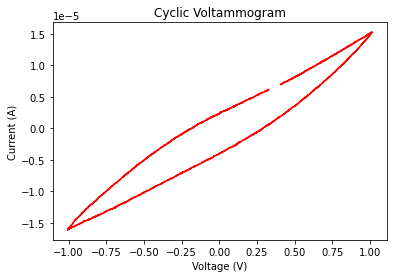

In [91]:
#Produces CV graph
cyc_volt('m014/waveforms/acq0001.csv')